## Transfer Learning

In [39]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [40]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [41]:
DATA_PATH = '/media/josh/MyData2SSD/Databases/cifar-100-python'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64

# Transform for ImageNet pre-trained models
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

# Transform for CIFAR-100 (if not using pretrained models)
transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.507, 0.487, 0.441], [0.267, 0.256, 0.276])
            ])

# Training set loader
cifar100_train = datasets.CIFAR100(DATA_PATH, train=True, download=True,
                                   transform=transform_imagenet)
train_loader = DataLoader(cifar100_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar100_val = datasets.CIFAR100(DATA_PATH, train=True, download=True,
                                 transform=transform_imagenet)
val_loader = DataLoader(cifar100_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar100_val))))

# Testing set loader
cifar100_test = datasets.CIFAR100(DATA_PATH, train=False, download=True,
                                  transform=transform_imagenet)
test_loader = DataLoader(cifar100_test, batch_size=MINIBATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [42]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Usar GPU

In [43]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


### Mostrar imágenes

Files already downloaded and verified
La imagen muestreada representa un: pickup_truck


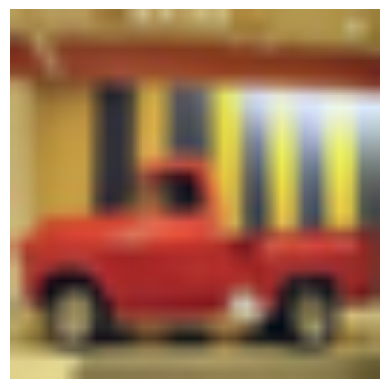

In [44]:
# Cargar CIFAR-100 y sus clases
cifar100_classes = datasets.CIFAR100(root='/media/josh/MyData2SSD/Databases/cifar-100-python', train=False, download=True).classes

# Función para mostrar la imagen
def plot_figure(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Obtiene un lote aleatorio del test_loader
data_iter = iter(test_loader)
images, labels = next(data_iter)

# Selecciona un índice aleatorio del lote
rnd_sample_idx = np.random.randint(len(images))
print(f'La imagen muestreada representa un: {cifar100_classes[labels[rnd_sample_idx]]}')

# Preprocesa y muestra la imagen
image = images[rnd_sample_idx]
image = (image - image.min()) / (image.max() - image.min())  # Normalización de la imagen
plot_figure(image)

### Calcular Accuracy

In [45]:
def accuracy(model, loader, device='cuda'):
    num_correct = 0
    num_total = 0
    model.eval()  # Pone el modelo en modo de evaluación
    model = model.to(device=device)  # Asegura que el modelo esté en el dispositivo correcto

    with torch.no_grad():  # No se necesita calcular gradientes durante la evaluación
        for xi, yi in loader:
            xi = xi.to(device=device, dtype=torch.float32)  # Mueve las imágenes al dispositivo correcto
            yi = yi.to(device=device, dtype=torch.long)  # Mueve las etiquetas al dispositivo correcto

            scores = model(xi)  # Predicción del modelo: (mb_size, num_classes)
            _, pred = scores.max(dim=1)  # Obtiene las predicciones (índices de las clases)

            num_correct += (pred == yi).sum().item()  # Suma el número de aciertos
            num_total += yi.size(0)  # Cuenta el número total de ejemplos procesados

    accuracy = float(num_correct) / num_total  # Calcula la precisión
    return accuracy

### Cargar modelo pre-cargado

In [46]:
model_resnet18 = models.resnet18(pretrained=True)

#### Exploremos el modelo

In [47]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [48]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [49]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [50]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [51]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [52]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [53]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [54]:
def train(model, optimiser, train_loader, val_loader, epochs=20, device='cuda', scheduler=None):
    model = model.to(device=device)  # Mueve el modelo al dispositivo (GPU o CPU) al inicio

    for epoch in range(epochs):
        model.train()  # Asegúrate de que el modelo esté en modo entrenamiento
        total_loss = 0  # Para almacenar la pérdida total en cada época

        # Itera a través de los lotes de entrenamiento
        for i, (xi, yi) in enumerate(train_loader):
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)

            # Hacer las predicciones
            scores = model(xi)

            # Calcular la pérdida
            cost = F.cross_entropy(input=scores, target=yi)

            # Retropropagar y actualizar los parámetros
            optimiser.zero_grad()  # Limpiar los gradientes previos
            cost.backward()  # Calcular los gradientes
            optimiser.step()  # Actualizar los parámetros

            total_loss += cost.item()  # Acumula la pérdida

        # Calcula la precisión al final de cada época
        acc = accuracy(model, val_loader, device=device)

        # Imprimir resultados de la época
        print(f'Epoch: {epoch+1}/{epochs}, Costo: {total_loss/len(train_loader):.4f}, Accuracy: {acc:.4f}')

        # Si estás utilizando un scheduler, actualiza la tasa de aprendizaje
        if scheduler:
            scheduler.step()

In [55]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 40

# Definir el modelo con 'model_aux' (este modelo debe ser una red preentrenada o parte de la red que hayas creado)
model1 = nn.Sequential(
    model_aux,  # Aquí debe estar tu modelo auxiliar preentrenado
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=100, bias=True)  # 512 es el tamaño de entrada de la salida de model_aux
)

# Definir el optimizador
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

In [56]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [57]:
train(model1, optimiser, train_loader, val_loader, epochs=epochs, device=device)

Epoch: 1/20, Costo: 2.8513, Accuracy: 0.4932
Epoch: 2/20, Costo: 1.8342, Accuracy: 0.5414
Epoch: 3/20, Costo: 1.6110, Accuracy: 0.5550
Epoch: 4/20, Costo: 1.5047, Accuracy: 0.5652
Epoch: 5/20, Costo: 1.4320, Accuracy: 0.5734
Epoch: 6/20, Costo: 1.3871, Accuracy: 0.5708
Epoch: 7/20, Costo: 1.3437, Accuracy: 0.5778
Epoch: 8/20, Costo: 1.3152, Accuracy: 0.5690
Epoch: 9/20, Costo: 1.2871, Accuracy: 0.5784
Epoch: 10/20, Costo: 1.2653, Accuracy: 0.5802
Epoch: 11/20, Costo: 1.2437, Accuracy: 0.5802
Epoch: 12/20, Costo: 1.2312, Accuracy: 0.5794
Epoch: 13/20, Costo: 1.2171, Accuracy: 0.5836
Epoch: 14/20, Costo: 1.1979, Accuracy: 0.5808
Epoch: 15/20, Costo: 1.1834, Accuracy: 0.5788
Epoch: 16/20, Costo: 1.1731, Accuracy: 0.5804
Epoch: 17/20, Costo: 1.1654, Accuracy: 0.5886
Epoch: 18/20, Costo: 1.1540, Accuracy: 0.5832
Epoch: 19/20, Costo: 1.1472, Accuracy: 0.5872
Epoch: 20/20, Costo: 1.1407, Accuracy: 0.5794


In [58]:
acc_test = accuracy(model1, test_loader, device=device)
print(f'Precisión en el conjunto de prueba: {acc_test:.4f}')

Precisión en el conjunto de prueba: 0.5914


In [59]:
model_save_path = r"C:\Users\Juanja Malo\Desktop\EntrenamientoMultilabel\resnet18_cifar100.pth"
torch.save(model1.state_dict(), model_save_path)
print(f"Modelo guardado en: {model_save_path}")

print("Entrenamiento y evaluación finalizados.")

Modelo guardado en: C:\Users\Juanja Malo\Desktop\EntrenamientoMultilabel\resnet18_cifar100.pth
Entrenamiento y evaluación finalizados.


# Cargar el modelo guardado

In [64]:
model_resnet18 = models.resnet18(pretrained=True)
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

model1 = nn.Sequential(
    model_aux,
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=100, bias=True)
)

# Cargar los pesos entrenados
model1.load_state_dict(torch.load('resnet18_cifar100.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))

# Configurar el modelo en modo evaluación
model1.eval()


C:\Users\Juanja Malo\AppData\Local\Temp\ipykernel_2200\1970512979.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1.load_state_dict(torch.load('resnet18_cifar100.p

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [65]:
# Cargar en un dispositivo específico
model1.train()


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
train(model1, optimiser, train_loader, val_loader, epochs=40, device=device)

Epoch: 1/40, Costo: 1.1107, Accuracy: 0.5772
Epoch: 2/40, Costo: 1.1071, Accuracy: 0.5790
Epoch: 3/40, Costo: 1.1089, Accuracy: 0.5822


In [ ]:
acc_test = accuracy(model1, test_loader, device=device)
print(f'Precisión en el conjunto de prueba: {acc_test:.4f}')

In [ ]:
model_save_path = r"C:\Users\Juanja Malo\Desktop\EntrenamientoMultilabel\resnet18_cifar100_2.pth"
torch.save(model1.state_dict(), model_save_path)
print(f"Modelo guardado en: {model_save_path}")

print("Entrenamiento y evaluación finalizados.")

# Predicion

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image

# Transformación para ResNet-18 preentrenado
transform = T.Compose([
    T.Resize(224),  # Cambiar tamaño a 224x224
    T.ToTensor(),   # Convertir a tensor
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # Normalización de ImageNet
])

# Cargar el modelo y pesos entrenados
model1.load_state_dict(torch.load('model1_weights.pth', map_location=torch.device('cuda' if torch.cuda.is_available() else 'cpu')))
model1.eval()

# Preprocesar una imagen
image = Image.open('path_to_image.jpg').convert('RGB')
input_tensor = transform(image).unsqueeze(0)

# Mover la imagen y el modelo al dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_tensor = input_tensor.to(device)
model1 = model1.to(device)

# Realizar predicción
with torch.no_grad():
    outputs = model1(input_tensor)
    _, predicted_class = torch.max(outputs, dim=1)

# Mapear clase a etiqueta (si tienes un diccionario)
idx_to_class = {idx: label for idx, label in enumerate(cifar100_classes)}
predicted_label = idx_to_class[predicted_class.item()]

print(f'Predicción: {predicted_label}')
